In [1]:
%matplotlib inline

This notebook includes preprocessing and analysis of EEG data from two participants. It is structed as follows:
- Preprocessing: preproccesing of data
    - Participant 1: Preprocessing of data from participant 1 is described and thoroughly visualized. The code in this part is well-commented, and all choices are stated. 
    - Participant 2: Preprocessing of data from participant 2. Less commented and visualized, except if choice/argument differ from participant. 
- Analysis: analysis of evoked data

# Preprocessing

## Participant 1

#### Load data

In [1]:
import mne
import pandas as pd
import os
import copy
from trigger_function import convert_triggers

In [2]:
raw1 = mne.io.read_raw_fif('eeg_data/p1-raw.fif', preload=True)
raw1.load_data()

Opening raw data file eeg_data/p1-raw.fif...
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.
Reading 0 ... 1214579  =      0.000 ...  1214.579 secs...


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

#### Filtering

Filtering with lowpass filter at 40 Hz to exclude electronic noise (typically at 50 Hz), while highpass filter is 0.1 Hz. Do filters one at time because

In [3]:
raw1_filtered = raw1.copy().filter(None, 40)
raw1_filtered = raw1_filtered.filter(0.1, None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



In [4]:
#Inspect data - see that data was obtained with 32 channels and sampling rate of 1000 Hz (one every milisecond)
raw1_filtered.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

#### Visual inspection - bad channels?

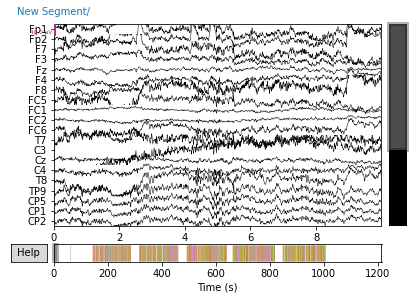

In [5]:
raw1_filtered.plot();

Channel C3 look bad (have some drifts)

In [6]:
#Marking channels that are bad - C3 is bad
raw1_filtered.info['bads'] = ['C3']

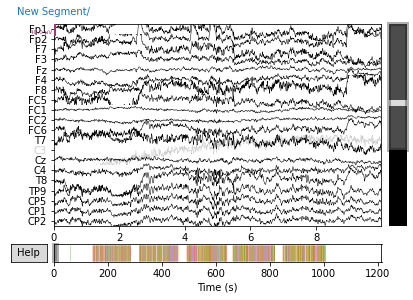

In [7]:
#Plot again to see effect of removing bad channel
raw1_filtered.plot();

Grey line shows the removed channnel - clearly some drifts in that. Other channels show indications of eyeblinks

#### Artefact removal

##### ICA

By setting n_components=0.95, we let the ICA run until 95 % of variance is explained instead of manually deciding on number of components to use. 

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 11 components
Fitting ICA took 14.8s.


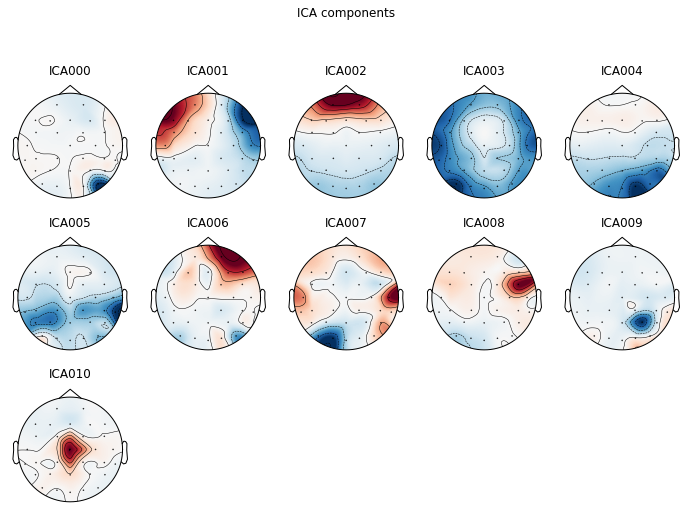

In [8]:
## set up and fit the ICA, including random state to ensure identical results each run
ica1 = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica1.fit(raw1_filtered)
ica1.plot_components();

Compoment 001 is almost definitely a saccade, while component 002 most likely is an eyeblink.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


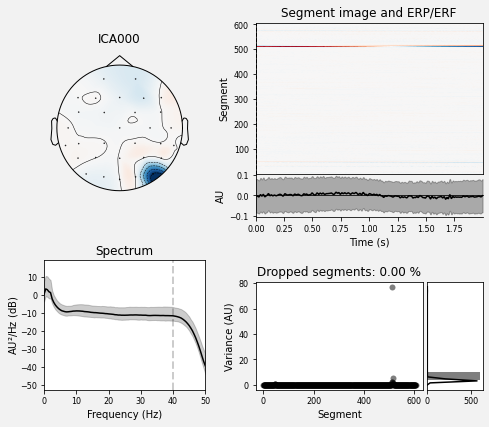

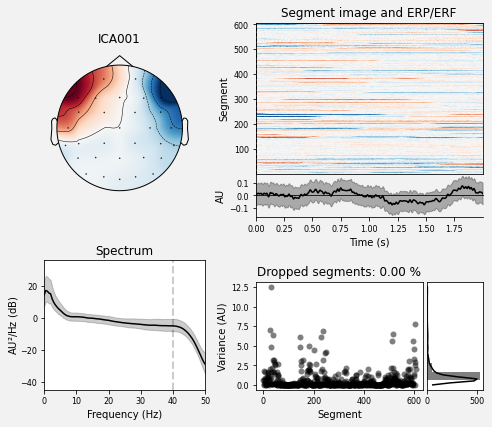

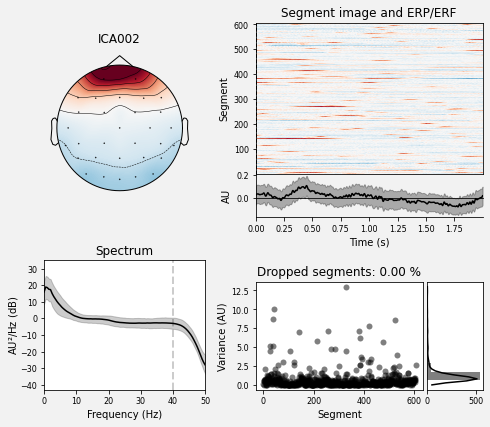

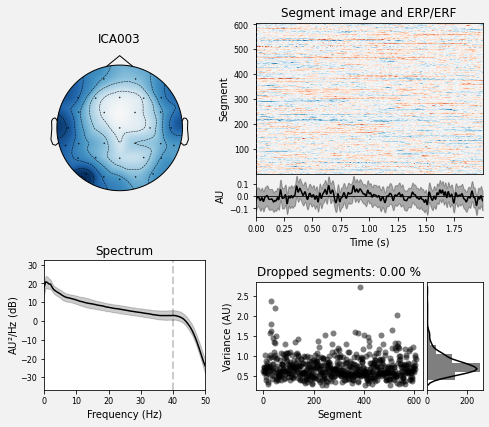

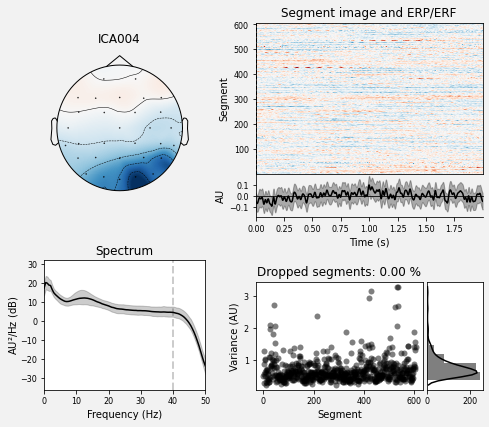

In [9]:
ica1.plot_properties(raw1_filtered); 

Creating RawArray with float64 data, n_channels=11, n_times=1214580
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.


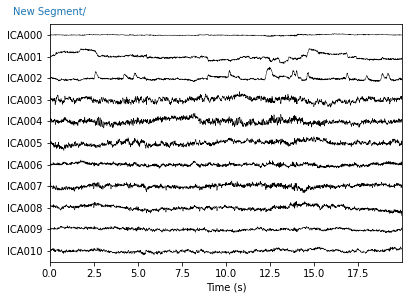

In [10]:
ica1.plot_sources(raw1_filtered, show_scrollbars=False);

This plot along with plot_properties indicate that component ICA000 is somehow a dead signal, while ICA001 again looks like a saccade due to the "boxes" in the signal. ICA002 could still likely be an eyeblink. We therefore remove ICAs 000, 001 and 002.

In [11]:
filtered1 = raw1_filtered.copy() #Making a copy of the filtered data to actually apply the ICA to. 
ica1.exclude = [0, 1, 2]
ica1.apply(filtered1)

Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

#### Epoching

#### Event detection

Events are converted using Mads' function. It recodes key press events and sound events to reflect whether the event involved successful or failed inhibitions after stop signal. 

In [12]:
events1, _ = mne.events_from_annotations(filtered1) #We use events that are already included in the data
events1, event_id1 = convert_triggers(events1, return_event_ids=True)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']


C:\Users\stnyl\AppData\Local\Temp/ipykernel_10184/1432152285.py:3: RuntimeWarning: event 30 missing from event_id will be ignored
  mne.viz.plot_events(events1, sfreq=filtered1.info['sfreq'], first_samp=filtered1.first_samp, event_id=event_id1);
C:\Users\stnyl\AppData\Local\Temp/ipykernel_10184/1432152285.py:3: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events1, sfreq=filtered1.info['sfreq'], first_samp=filtered1.first_samp, event_id=event_id1);


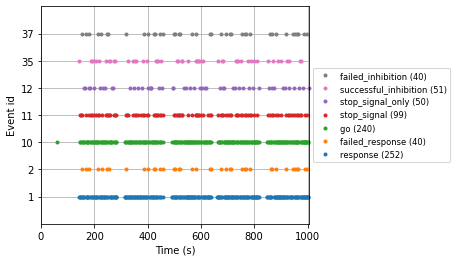

In [13]:
#visualize events - sampling frequency was 1000 Hz and the experiment lasted just above 1000 ms as
#We see that events are evenly distributed throughout the experiment
mne.viz.plot_events(events1, sfreq=filtered1.info['sfreq'], first_samp=filtered1.first_samp, event_id=event_id1); 

We epoch 0.5 seconds before and 1.5 seconds after stimulus was presented. This window allows to investigate brain activity related to the event within a relatively long time period prior and posterior to stimulus. For some events, this might mean that epochs overlap, if they were presented with less than 2 second intervals. If any datapoints are above the 150 microVolt threshold, they are excluded any datapoint above this threshold are definitely not brain data, and by setting a relatively high threshold we do not risk throwing away any of the very scarce data we have, since only two participants were included. 

In [14]:
reject_criteria = dict(eeg=150e-6)  
epochs1 = mne.Epochs(filtered1, events1, event_id1,
                    baseline=(None,0), preload=True, 
                    tmin=-0.5, tmax=1.5, reject=reject_criteria)

Not setting metadata
Not setting metadata
772 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 772 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['P8', 'O2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['P4']
7 bad epochs dropped


We see that 7 bad epochs are dropped based on the criteria defined. 

In [15]:
epochs1

Number of events,765
Events,failed_inhibition: 40failed_response: 40go: 238response: 250stop_signal: 98stop_signal_only: 49successful_inhibition: 50
Time range,-0.500 – 1.500 sec
Baseline,-0.500 – 0.000 sec


We see that a total of 765 events remain, hereof 40 events were failed inhibitions while 50 were successful inhibitions. These are the events of main interest to our analysis

#### Average epochs to get evoked signals

We make sure that there is the same amount of events in each of the two conditions of interest

In [16]:
conds = ['failed_inhibition', 'successful_inhibition']
epochs1.equalize_event_counts(conds)

Dropped 10 epochs: 55, 117, 129, 135, 174, 180, 184, 389, 395, 400


(<Epochs |  755 events (all good), -0.5 - 1.5 sec, baseline -0.5 – 0 sec, ~368.9 MB, data loaded,
  'failed_inhibition': 40
  'failed_response': 40
  'go': 238
  'response': 250
  'stop_signal': 98
  'stop_signal_only': 49
  'successful_inhibition': 40>,
 array([ 55, 117, 129, 135, 174, 180, 184, 389, 395, 400], dtype=int64))

In [17]:
success_epochs1 = epochs1['successful_inhibition']
failed_epochs1 = epochs1['failed_inhibition']

Plot epochs before averaging

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


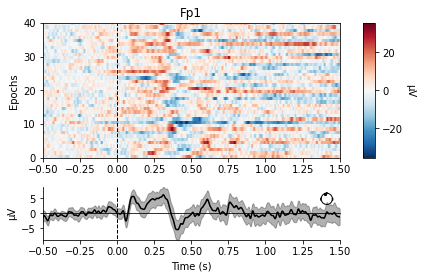

[<Figure size 432x288 with 4 Axes>]

In [18]:
#Visualize different channels - only one shown. Just for visualizing epochs for manual inspection
success_epochs1.plot_image(picks=['Fp1'])

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


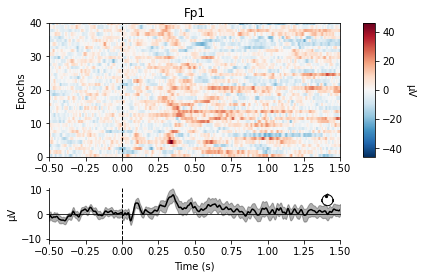

[<Figure size 432x288 with 4 Axes>]

In [19]:
failed_epochs1.plot_image(picks=['Fp1'])

In [20]:
success_evoked1 = success_epochs1.average()
failed_evoked1 = failed_epochs1.average()

Plotting evoked signals for all channels along with the global field power (GFP) - a measure of spatial standard deviation of electrical signals at each time point. Thuss when the green curve (GFP) is high, the variance in the signal of the channels is high. 

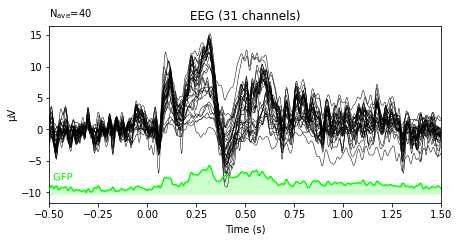

In [21]:
success_evoked1.plot(gfp=True);

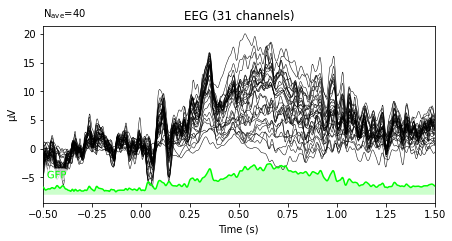

In [22]:
failed_evoked1.plot(gfp=True);

Eyeballing these plots, it seems that between around 400 ms and 1000 ms after stimulus onset for the failed inhibition trials, variation between electrodes is quite high and there is no clear picture of what happens. Earlier components aroun 100-250  ms are more clear. For the successful inhibition trials, variance is quite low across time 

Plot to compare evoked signals

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


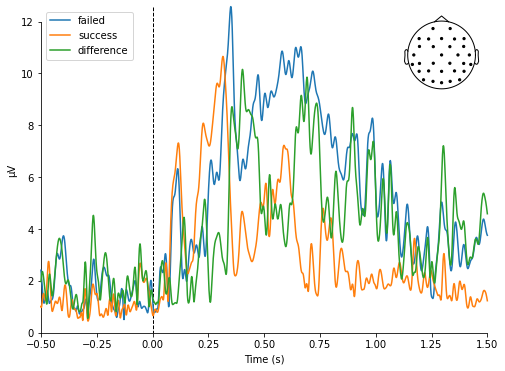

[<Figure size 576x432 with 2 Axes>]

In [34]:
diff = mne.combine_evoked([failed_evoked1, success_evoked1], weights=[1,-1])
mne.viz.plot_compare_evokeds(evokeds=dict(failed=failed_evoked1, success=success_evoked1, difference=diff), 
                             show_sensors='upper right')

Plot indicates that there does seem to be a difference for the failed and successful trials (just based on eyeballing)

No projector specified for this dataset. Please consider the method self.add_proj.


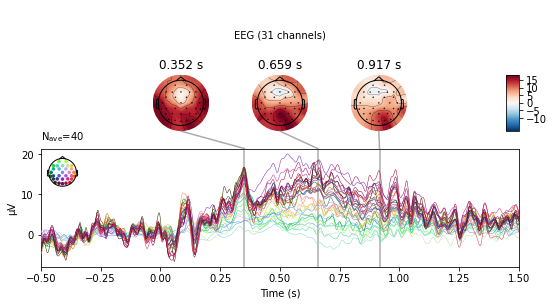

No projector specified for this dataset. Please consider the method self.add_proj.


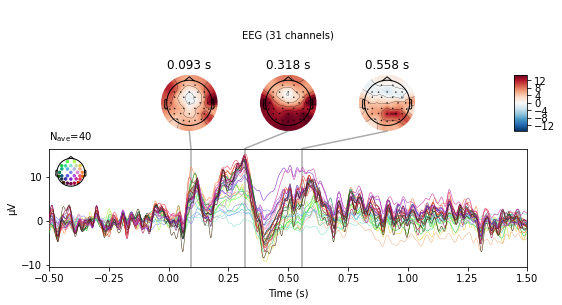

No projector specified for this dataset. Please consider the method self.add_proj.


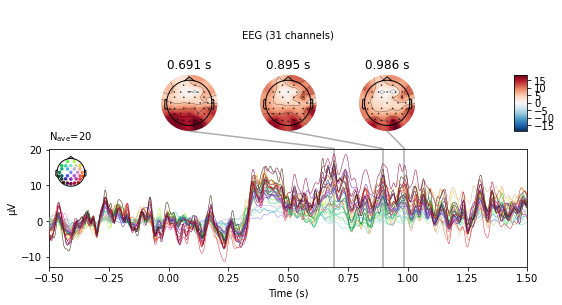

In [32]:
failed_evoked1.plot_joint();
success_evoked1.plot_joint();
diff.plot_joint();

Plotting the difference signal indicates that there is a stronger difference between the two conditions (failed/successful inhibition) for the later components.

## Participant 2

#### Load data

In [35]:
raw2 = mne.io.read_raw_fif('eeg_data/p2-raw.fif', preload=True)
raw2.load_data()

Opening raw data file eeg_data/p2-raw.fif...
    Range : 0 ... 989399 =      0.000 ...   989.399 secs
Ready.
Reading 0 ... 989399  =      0.000 ...   989.399 secs...


<Raw | p2-raw.fif, 32 x 989400 (989.4 s), ~241.6 MB, data loaded>

#### Filtering

In [36]:
raw2_filtered = raw2.copy().filter(None, 40)
raw2_filtered = raw2_filtered.filter(0.1, None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



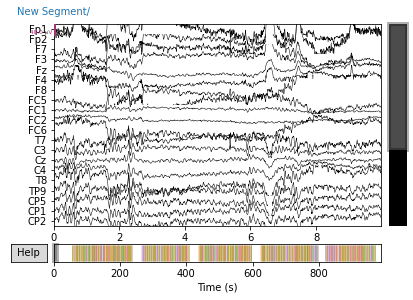

In [38]:
raw2_filtered.plot();

In [ ]:
#Marking bad channels
# raw2_filtered.info['bads'] = ['']

<Info | 13 non-empty values
 bads: 1 items (C3)
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

#### Artefact removal

##### ICA

By setting n_components=0.95, we let the ICA run until 95 % of variance is explained instead of manually deciding on number of components to use. 

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 10 components
Fitting ICA took 14.6s.


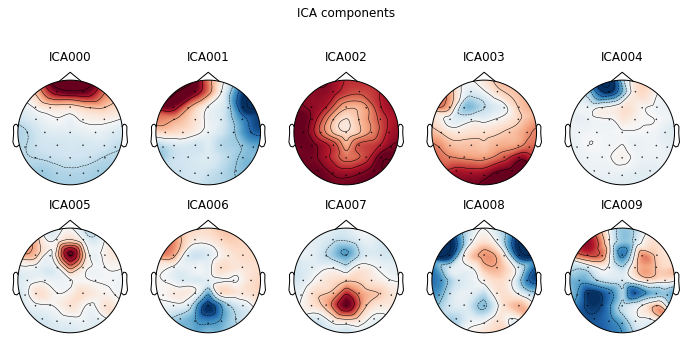

In [39]:
## set up and fit the ICA
ica2 = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica2.fit(raw2_filtered)
ica2.plot_components(); #, picks=ica.exclude

Component ICA000 looks like an eyeblink, ICA001 like a saccade - these are removed

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


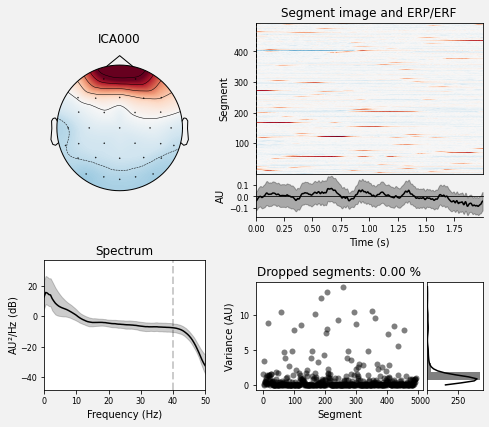

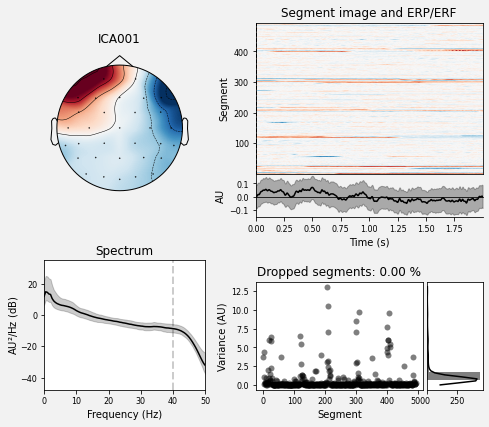

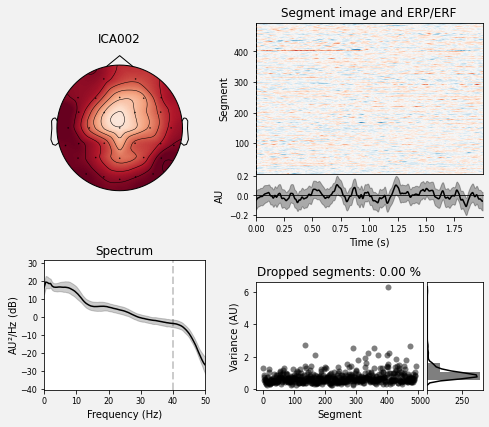

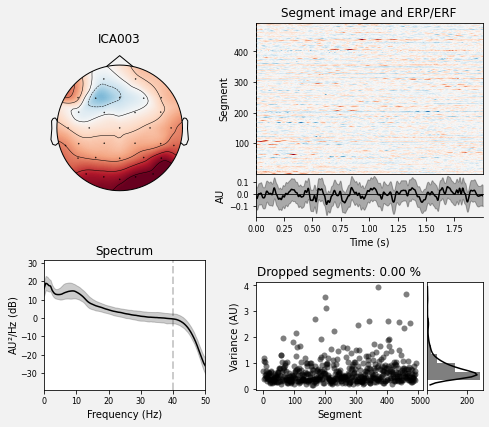

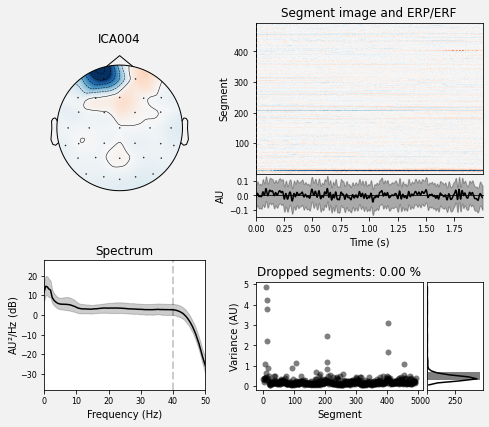

In [40]:
ica2.plot_properties(raw2_filtered); 

Creating RawArray with float64 data, n_channels=10, n_times=989400
    Range : 0 ... 989399 =      0.000 ...   989.399 secs
Ready.


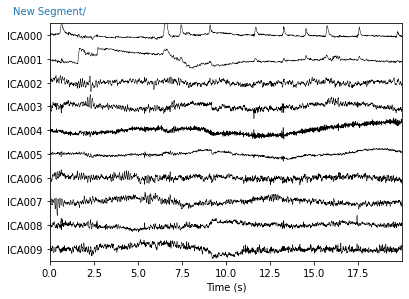

In [41]:
ica2.plot_sources(raw2_filtered, show_scrollbars=False);

In [42]:
filtered2 = raw2_filtered.copy() 
ica2.exclude = [0, 1]
ica2.apply(filtered2)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


<Raw | p2-raw.fif, 32 x 989400 (989.4 s), ~241.6 MB, data loaded>

#### Epoching

#### Event detection

In [43]:
events2, _ = mne.events_from_annotations(filtered2) #We use events that are already included in the data
events2, event_id2 = convert_triggers(events2, return_event_ids=True) #Convert them using Mads' function to define

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']


In [44]:
reject_criteria = dict(eeg=150e-6)  #If any datapoints are above the 150 microVolt threshold, they are excluded
epochs2 = mne.Epochs(filtered2, events2, event_id2,
                    baseline=(None,0), preload=True, 
                    tmin=-0.5, tmax=1.5, reject=reject_criteria)

Not setting metadata
Not setting metadata
855 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 855 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10', 'P7', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10', 'P7', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO9', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['PO9', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'PO10']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'PO10']
    Rej

#### Average epochs to get evoked signals

In [45]:
conds = ['failed_inhibition', 'successful_inhibition']
epochs2.equalize_event_counts(conds)

Dropped 14 epochs: 20, 65, 72, 100, 112, 317, 350, 359, 373, 402, 431, 454, 461, 478


(<Epochs |  816 events (all good), -0.5 - 1.5 sec, baseline -0.5 – 0 sec, ~398.7 MB, data loaded,
  'failed_inhibition': 40
  'failed_response': 55
  'go': 267
  'response': 273
  'stop_signal': 95
  'stop_signal_only': 46
  'successful_inhibition': 40>,
 array([ 20,  65,  72, 100, 112, 317, 350, 359, 373, 402, 431, 454, 461,
        478], dtype=int64))

In [46]:
success_epochs2 = epochs2['successful_inhibition']
failed_epochs2 = epochs2['failed_inhibition']

In [47]:
success_evoked2 = success_epochs2.average()
failed_evoked2 = failed_epochs2.average()

Plotting evoked signals for all channels along with the global field power

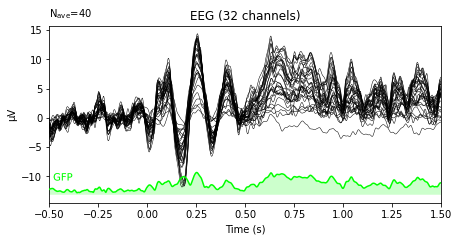

In [48]:
success_evoked2.plot(gfp=True);

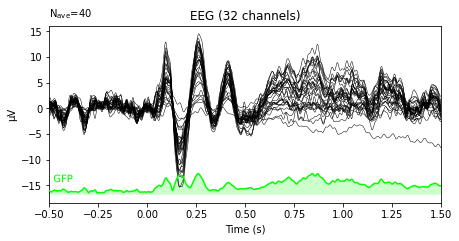

In [49]:
failed_evoked2.plot(gfp=True);

Plot to compare evoked signals

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


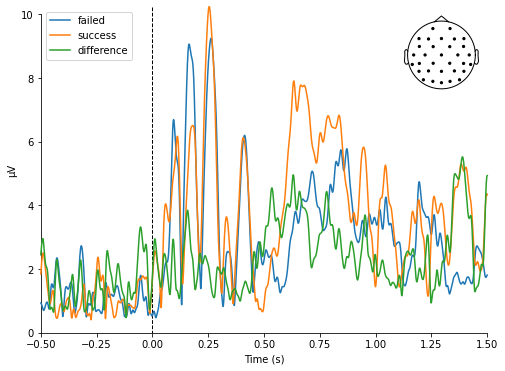

[<Figure size 576x432 with 2 Axes>]

In [50]:
diff = mne.combine_evoked([failed_evoked2, success_evoked2], weights=[1,-1])
mne.viz.plot_compare_evokeds(evokeds=dict(failed=failed_evoked2, success=success_evoked2, difference=diff), show_sensors='upper right')

No projector specified for this dataset. Please consider the method self.add_proj.


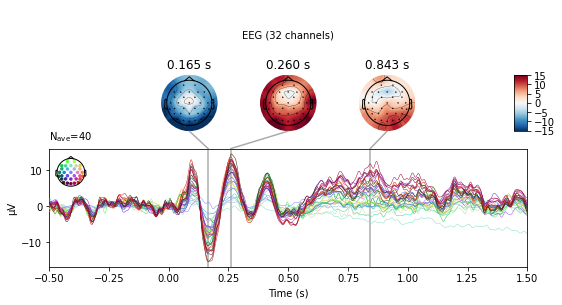

No projector specified for this dataset. Please consider the method self.add_proj.


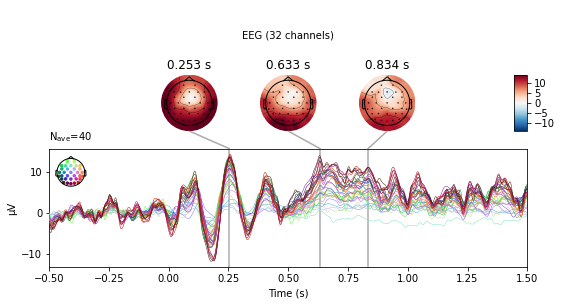

In [51]:
failed_evoked2.plot_joint();
success_evoked2.plot_joint();

# Analysis

Now we fit a logistic regression to predict whether a trial was failed or successful inhibition. 

In [66]:
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator, GeneralizingEstimator, Scaler, cross_val_multiscore, LinearModel, get_coef, Vectorizer, CSP

In [54]:
event_id1

{'stop_signal': 11,
 'go': 10,
 'response': 1,
 'stop_signal_only': 12,
 'failed_response': 2,
 'failed_inhibition': 37,
 'successful_inhibition': 35}

As we wish to do a logistic regression between successful and failed inhibitions, we pick those from the epochs

In [71]:
#Creating variables for analysis
X = epochs1[conds].get_data() 
print(X.shape) #Shape is 80 trials, 32 channels, 2001 time points
y = epochs1[conds].events[:,2]  #select only successful inhibition (35) and failed inhibition (37)

(80, 32, 2001)


In [64]:
y[y==35] = 0 #Succesful is now 0
y[y==37] = 1 #Failed is now 1 - thus we predict whether a trial is failed inhibition or not
y

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

Prepare pipeline with cross-validation and test set of size 0.2, meaning that 1/5 of the data is test set. We also scale with the standard scaler, and then prepare the logistic regression. 

In [68]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=2021)
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))
time_decod = SlidingEstimator(clf, scoring='roc_auc') #apply classifier to each time point in a sliding estimator using corss-validation

In [69]:
scores = cross_val_multiscore(time_decod, X, y, cv=cv)

100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:35<00:00,   56.14it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:39<00:00,   50.59it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:40<00:00,   49.62it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:47<00:00,   42.19it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:43<00:00,   45.78it/s]


In [74]:
scores.shape #Shape is 5 CV folds 2001 time points

(5, 2001)

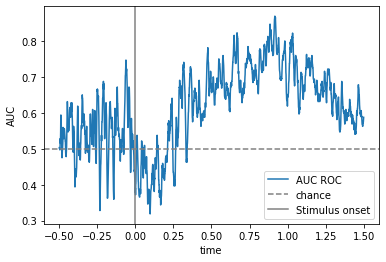

In [85]:
plt.plot(epochs1.times, scores.mean(axis=0), label="AUC ROC");
plt.axhline(0.5, label="chance", color="Grey", linestyle="dashed") 
plt.axvline(0, label="Stimulus onset", color="Grey")
plt.xlabel("time")
plt.ylabel("AUC")
plt.legend()

In [91]:
time_decod.get_params

<bound method BaseEstimator.get_params of <SlidingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel', LinearModel(model=LogisticRegression()))]),
         n_jobs=1, scoring='roc_auc', verbose=None)>>

In [92]:
time_decod.fit(X,y)

100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:28<00:00,   69.59it/s]


<SlidingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel', LinearModel(model=LogisticRegression()))]),
         n_jobs=1, scoring='roc_auc', verbose=None, fitted with 2001 estimators>

In [104]:
coef = get_coef(time_decod, 'filters_', inverse_transform=False)
coef.shape #32 channels, 2001 time points

(32, 2001)

We get one coefficient per channel per timepoint. Visualizinf the evoked array after calculating coefficients

No projector specified for this dataset. Please consider the method self.add_proj.


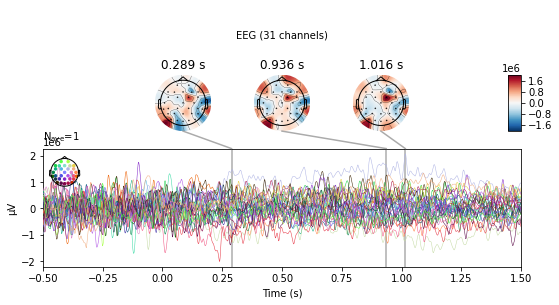

In [106]:
evoked_coef = mne.EvokedArray(coef,
                              epochs1.info,
                              tmin=epochs1.times[0])
evoked_coef.plot_joint(); 

This plot indicates that no channel is more interesting than the others